# Model 3rd リファクタリング版

このノートブックは、`16_model_3rd.ipynb`のリファクタリング版です。
前処理、Nadaraya-Watson推定、IPP推定をクラス化して実行します。

## 1. ライブラリのインポート

In [16]:
import sys
import os

# パスの追加（必要に応じて調整）
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

import japanize_matplotlib
japanize_matplotlib.japanize()
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from bayesian_statistics.model3_config import Model3Config, Model3Pipeline
from bayesian_statistics.model3_visualization import ObsidianVisualizer

# 警告の抑制
import warnings
warnings.filterwarnings('ignore')

## 2. 設定の定義

In [2]:
# データディレクトリの設定
data_dir = "/home/ohta/dev/bayesian_statistics/data/"

# 設定オブジェクトの作成
config = Model3Config(
    data_dir=data_dir,
    x_min=138,
    x_max=141,
    y_min=34,
    y_max=37,
    nw_sigma=500,
    nw_sigma_for_sites=0.1,
    mcmc_iterations=30000,
    burn_in=5000,
)

print("設定内容:")
print(f"  データディレクトリ: {config.data_dir}")
print(f"  領域: [{config.x_min}, {config.x_max}] × [{config.y_min}, {config.y_max}]")
print(f"  NWバンド幅: {config.nw_sigma} (グリッド), {config.nw_sigma_for_sites} (遺跡)")
print(f"  MCMCイテレーション: {config.mcmc_iterations} (バーンイン: {config.burn_in})")

設定内容:
  データディレクトリ: /home/ohta/dev/bayesian_statistics/data/
  領域: [138, 141] × [34, 37]
  NWバンド幅: 500 (グリッド), 0.1 (遺跡)
  MCMCイテレーション: 30000 (バーンイン: 5000)


## 3. パイプラインの実行

### 3.1 前処理

In [3]:
# パイプラインの初期化
pipeline = Model3Pipeline(config)

# 前処理の実行
preprocessor = pipeline.run_preprocessing()

=== 前処理を開始 ===
データを読み込んでいます...
標高データ: (1357520, 42)
黒曜石データ: (30070, 11)
遺跡データ: (274, 49)


In [4]:
# データの確認
print("=== データの確認 ===")
print(f"\n標高データの列: {preprocessor.df_elevation.columns[:10]}...")
print(f"\n黒曜石データの列: {preprocessor.df_obsidian.columns}")
print(f"\n遺跡データの列: {preprocessor.df_sites.columns[:10]}...")

=== データの確認 ===

標高データの列: ['grid_x', 'x', 'grid_y', 'y', 'mesh_code_5th', 'average_elevation', 'maximum_elevation', 'minimum_elevation', 'minimum_elevation_code', 'maximum_slope_angle']...

黒曜石データの列: ['緯度', '経度', '時期名', '時期', '備考', 'geometry', '産地', '産地カテゴリ', '遺跡ID', 'x_meter', 'y_meter']

遺跡データの列: ['遺跡名', '緯度', '経度', '都道府県', 'geometry', '遺跡ID', 'メッシュコード_1st', 'メッシュコード', 'x_meter', 'y_meter']...


### 3.2 Tobler距離の可視化（サンプル）

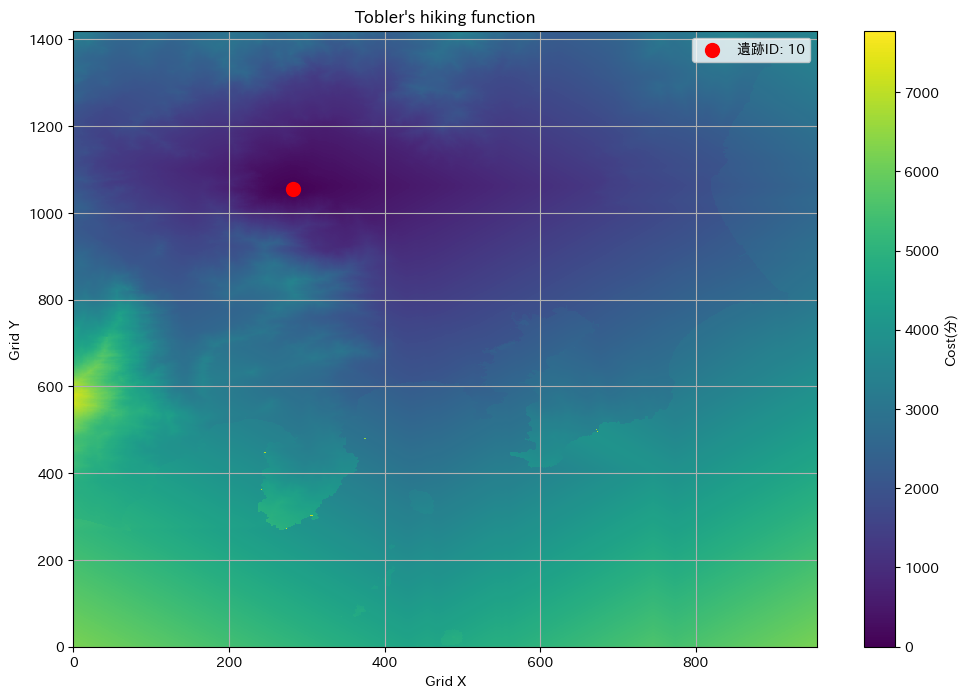

In [5]:
# 特定の遺跡からのTobler距離を可視化
import pickle

site_id = 10
site_grid_coords = preprocessor.convert_to_grid_coords()
x, y = site_grid_coords[site_id, 0], site_grid_coords[site_id, 1]

# 距離データの読み込み
with open(
    os.path.join(
        data_dir, "16_tobler_distance_with_coast_50_average", f"distance_siteID_{site_id}"
    ),
    mode="br",
) as fi:
    min_costs = pickle.load(fi)

# データフレームの作成
grid_info = preprocessor.create_grid_info()
width = grid_info["n_grid_x"]
height = grid_info["n_grid_y"]

min_costs_df = pl.DataFrame(
    {
        "grid_x": np.tile(np.arange(width), height),
        "grid_y": np.repeat(np.arange(height), width),
        f"cost_{site_id}": min_costs,
    }
)

# 可視化
fig = ObsidianVisualizer.create_grid_visualization(min_costs_df)
plt.scatter(x, y, color="red", s=100, label=f"遺跡ID: {site_id}")
plt.legend()
plt.show()

### 3.3 Nadaraya-Watson推定

In [6]:
# NW推定の実行
nw_estimator = pipeline.run_nadaraya_watson(preprocessor)


=== Nadaraya-Watson推定を開始 ===
重み行列を計算しています...
creating weights matrix...


calculating distance_W...
updating weights matrix...

全時期・全産地の推定を実行しています...


時期:   0%|          | 0/5 [00:00<?, ?it/s]

target_period: 0, target_origin: 神津島
target_period: 0, target_origin: 信州
target_period: 0, target_origin: 箱根
target_period: 0, target_origin: 高原山


時期:  20%|██        | 1/5 [00:08<00:35,  8.93s/it]

target_period: 1, target_origin: 神津島
target_period: 1, target_origin: 信州
target_period: 1, target_origin: 箱根
target_period: 1, target_origin: 高原山


時期:  40%|████      | 2/5 [00:17<00:26,  8.92s/it]

target_period: 2, target_origin: 神津島
target_period: 2, target_origin: 信州
target_period: 2, target_origin: 箱根
target_period: 2, target_origin: 高原山


時期:  60%|██████    | 3/5 [00:26<00:17,  8.87s/it]

target_period: 3, target_origin: 神津島
target_period: 3, target_origin: 信州
target_period: 3, target_origin: 箱根
target_period: 3, target_origin: 高原山


時期:  80%|████████  | 4/5 [00:35<00:08,  8.85s/it]

target_period: 4, target_origin: 神津島
target_period: 4, target_origin: 信州
target_period: 4, target_origin: 箱根
target_period: 4, target_origin: 高原山


時期: 100%|██████████| 5/5 [00:44<00:00,  8.89s/it]


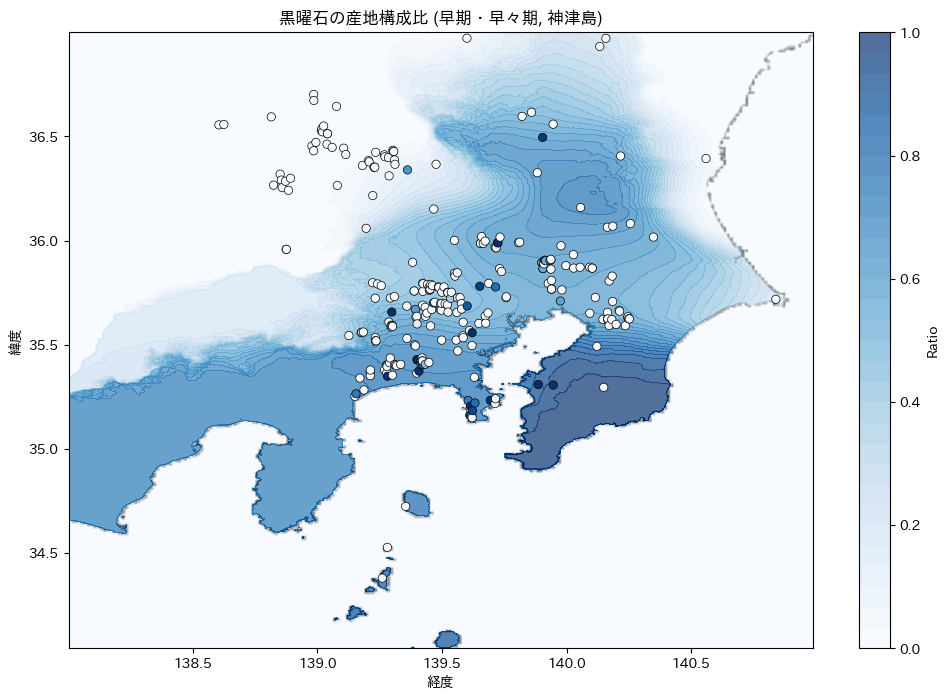

In [7]:
# 結果の確認（例：早期・早々期の神津島）
target_period = 0
target_origin = "神津島"

fig, ax = ObsidianVisualizer.plot_ratio_map(
    preprocessor.df_elevation,
    preprocessor.df_sites,
    target_period,
    target_origin,
    config.time_periods,
)
plt.show()

### 3.4 IPP推定

In [8]:
# IPP推定の実行
ipp_model = pipeline.run_ipp(preprocessor)


=== IPP推定を開始 ===
MCMCサンプリングを実行しています...


100%|██████████| 30000/30000 [00:41<00:00, 726.59it/s]


遺跡存在確率を計算しています...


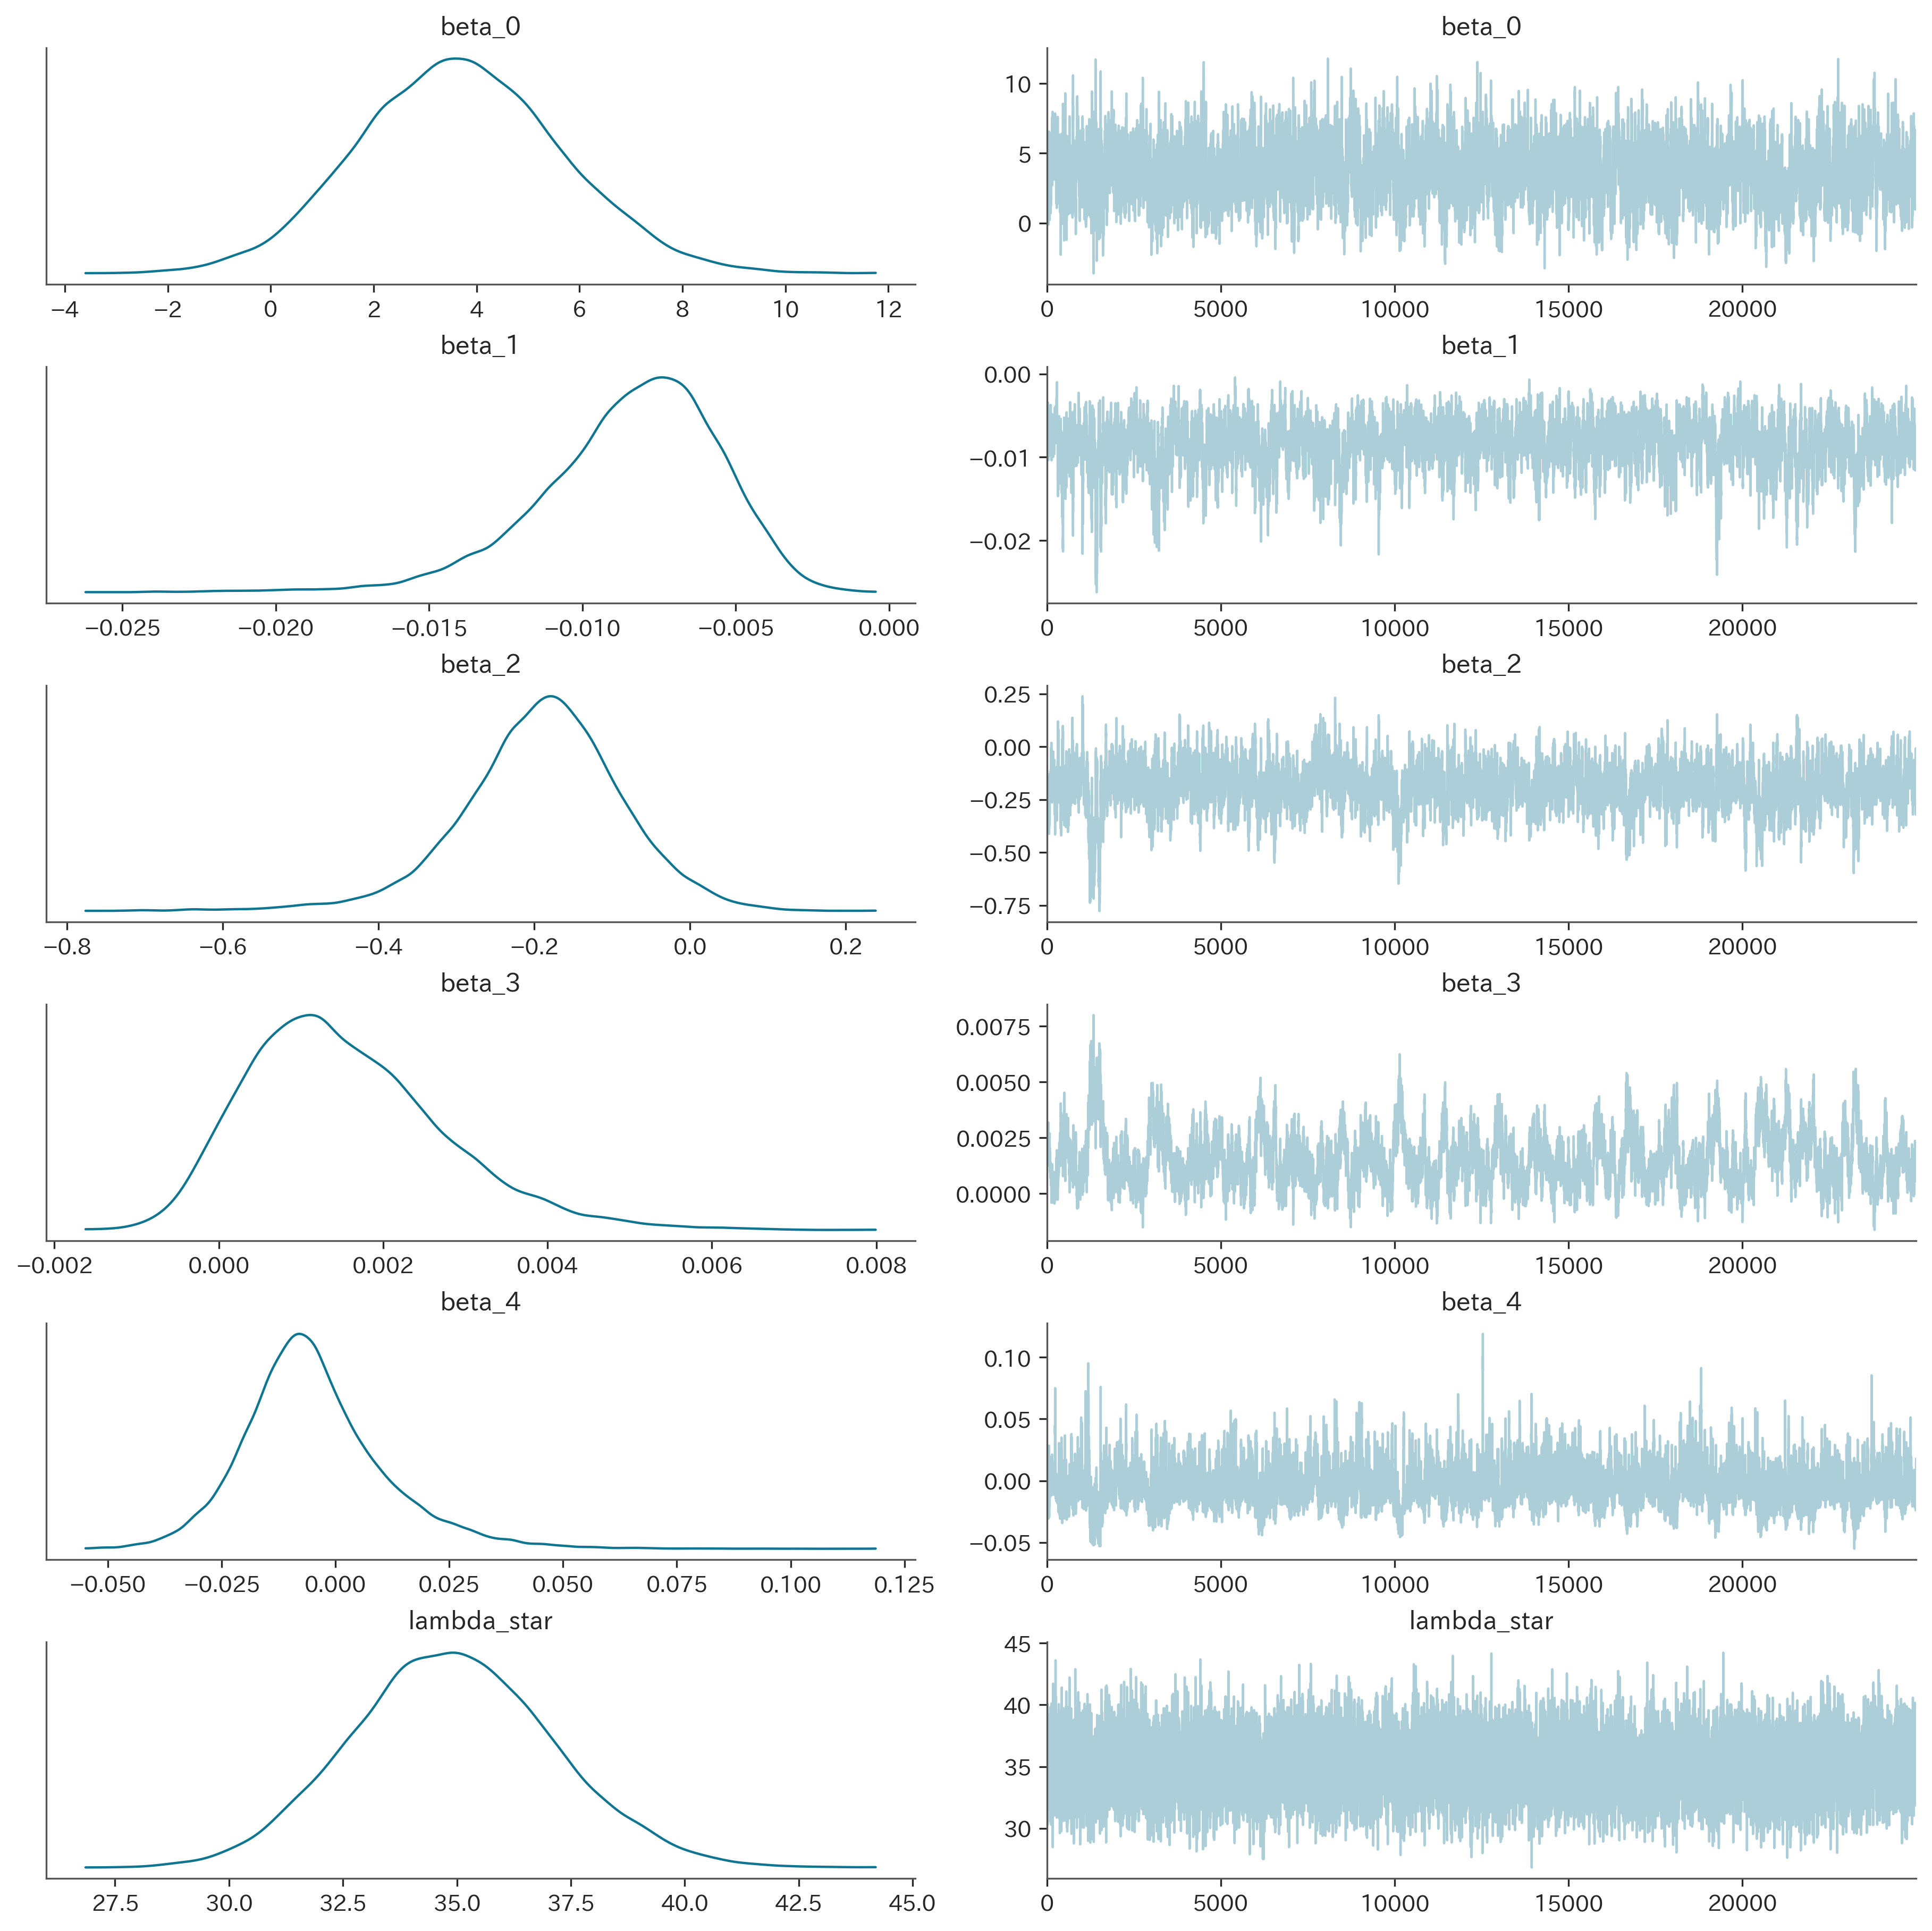

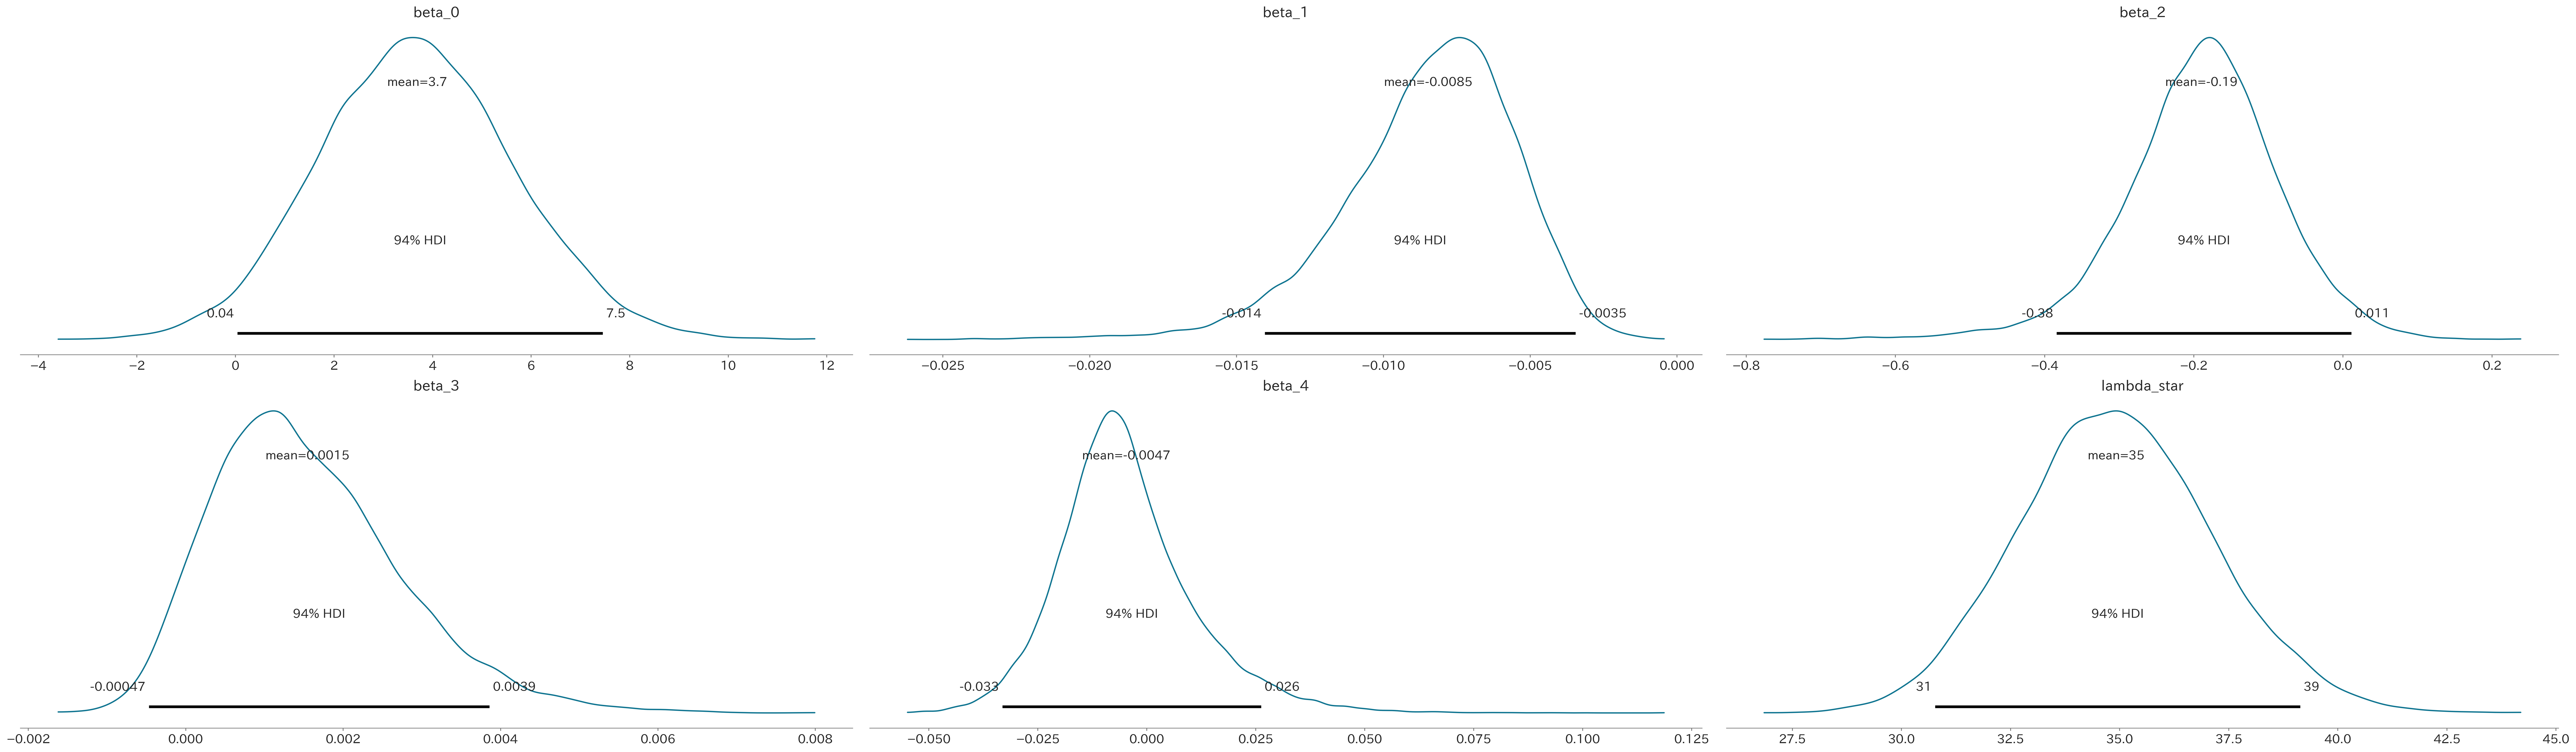

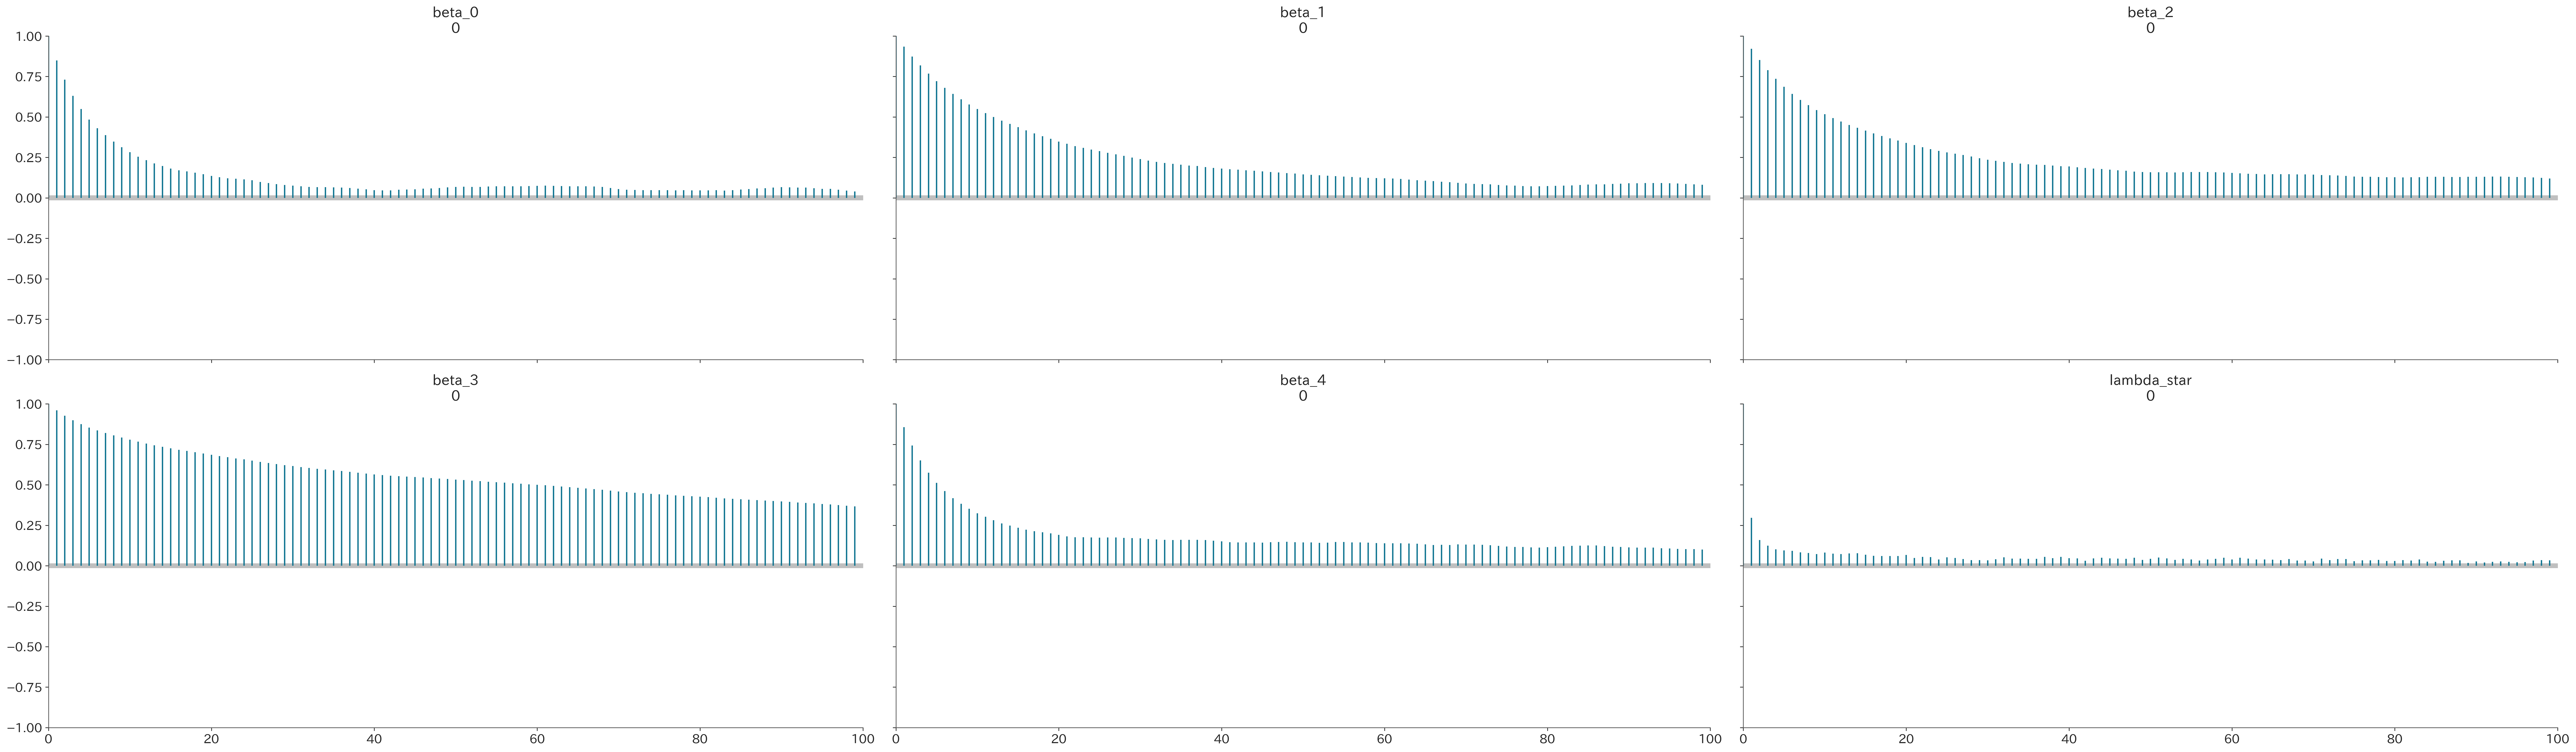

arviz - WARNING - Shape validation failed: input_shape: (1, 25000), minimum_shape: (chains=2, draws=4)


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_0        3.691  1.981   0.040    7.454      0.064    0.045     956.0   
beta_1       -0.008  0.003  -0.014   -0.003      0.000    0.000     420.0   
beta_2       -0.190  0.105  -0.384    0.011      0.006    0.005     396.0   
beta_3        0.002  0.001  -0.000    0.004      0.000    0.000     170.0   
beta_4       -0.005  0.016  -0.033    0.026      0.001    0.000     419.0   
lambda_star  34.918  2.231  30.769   39.139      0.049    0.034    2093.0   

             ess_tail  r_hat  
beta_0         2399.0    NaN  
beta_1          912.0    NaN  
beta_2          355.0    NaN  
beta_3          237.0    NaN  
beta_4          437.0    NaN  
lambda_star   12877.0    NaN  


In [9]:
# MCMC診断
idata = ipp_model.create_inference_data()
ObsidianVisualizer.plot_mcmc_diagnostics(idata)

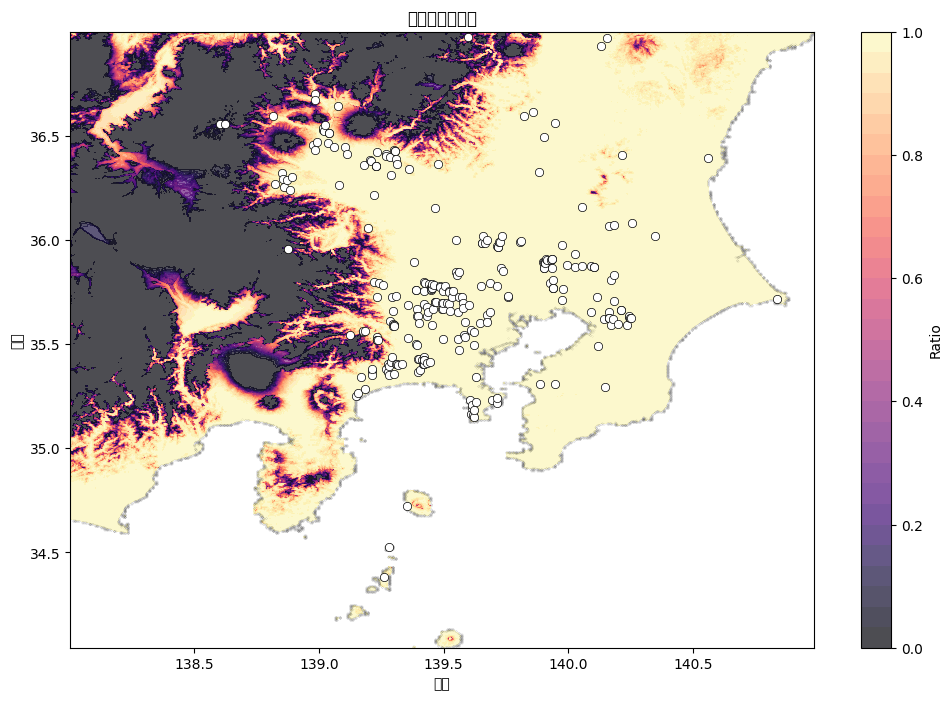

In [10]:
# 遺跡存在確率の可視化
fig, ax = ObsidianVisualizer.plot_site_probability(
    preprocessor.df_elevation,
    preprocessor.df_sites,
)
plt.show()

## 4. 全時期・全産地の可視化

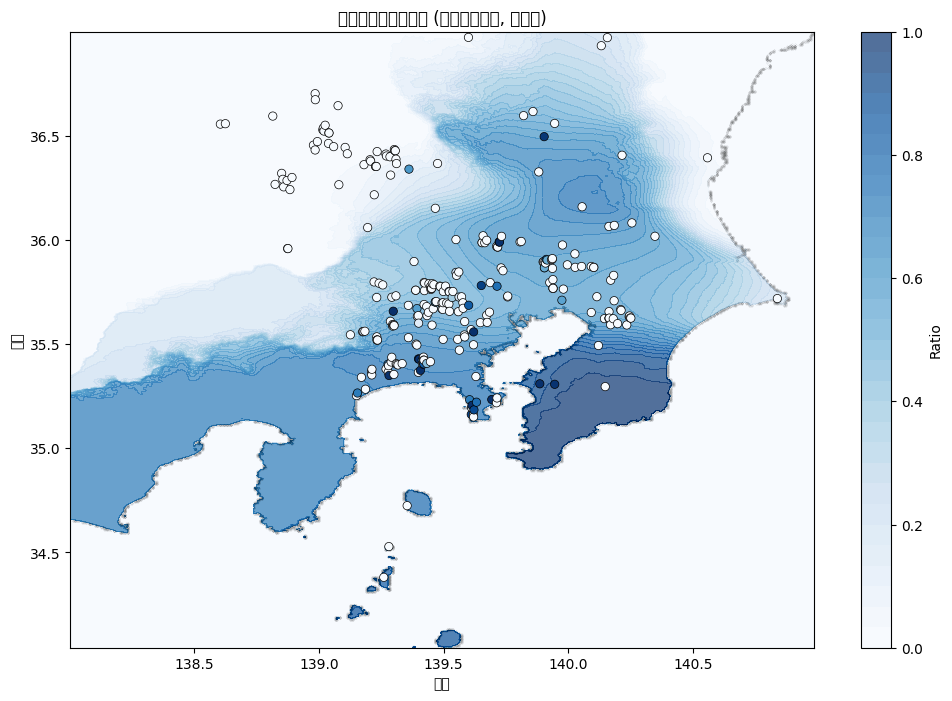

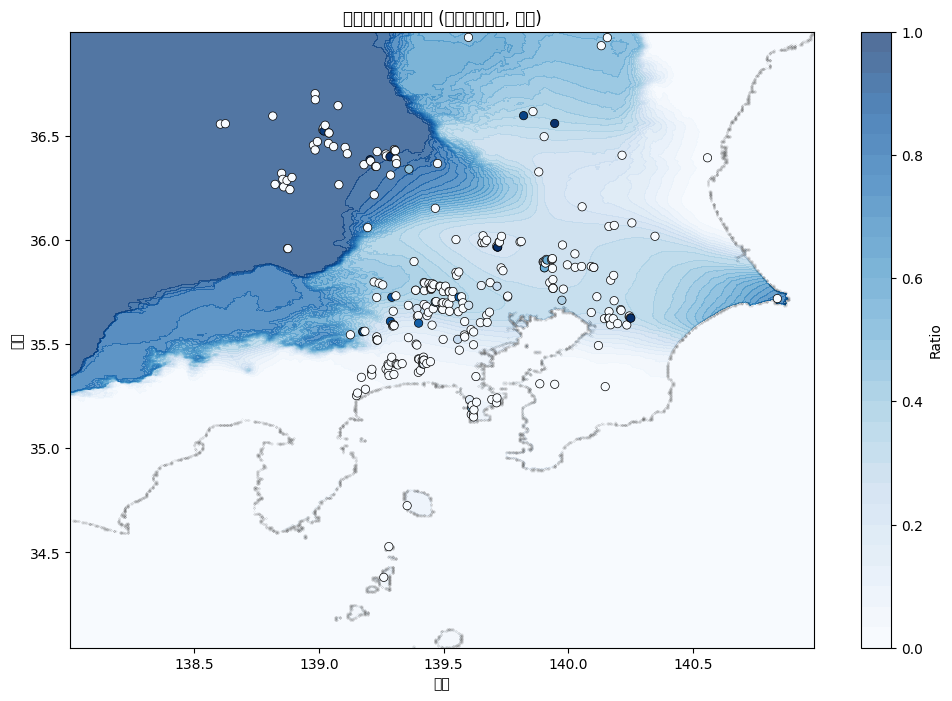

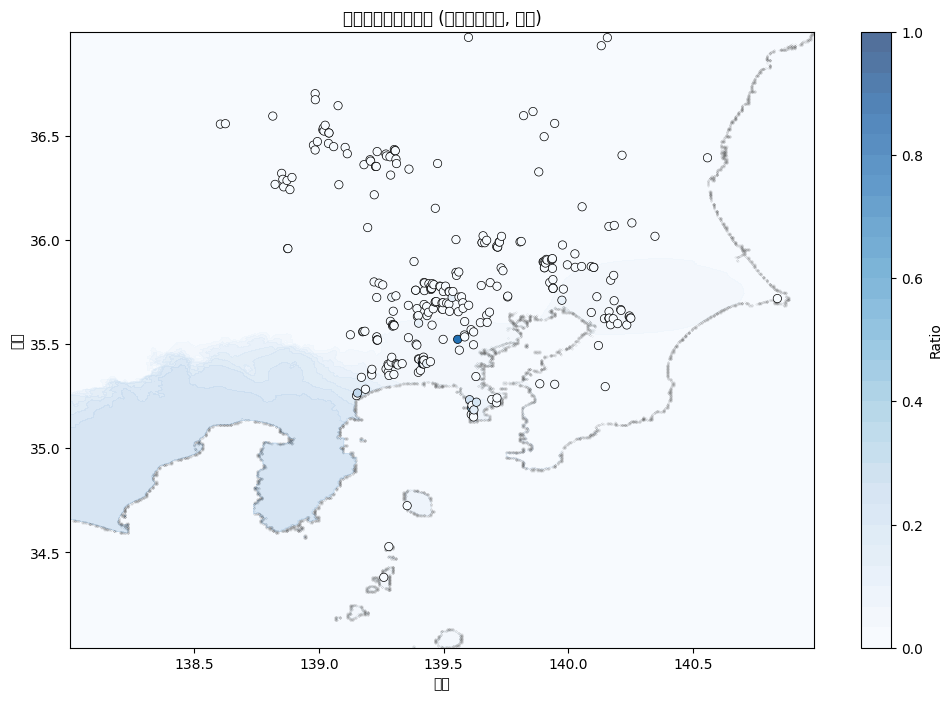

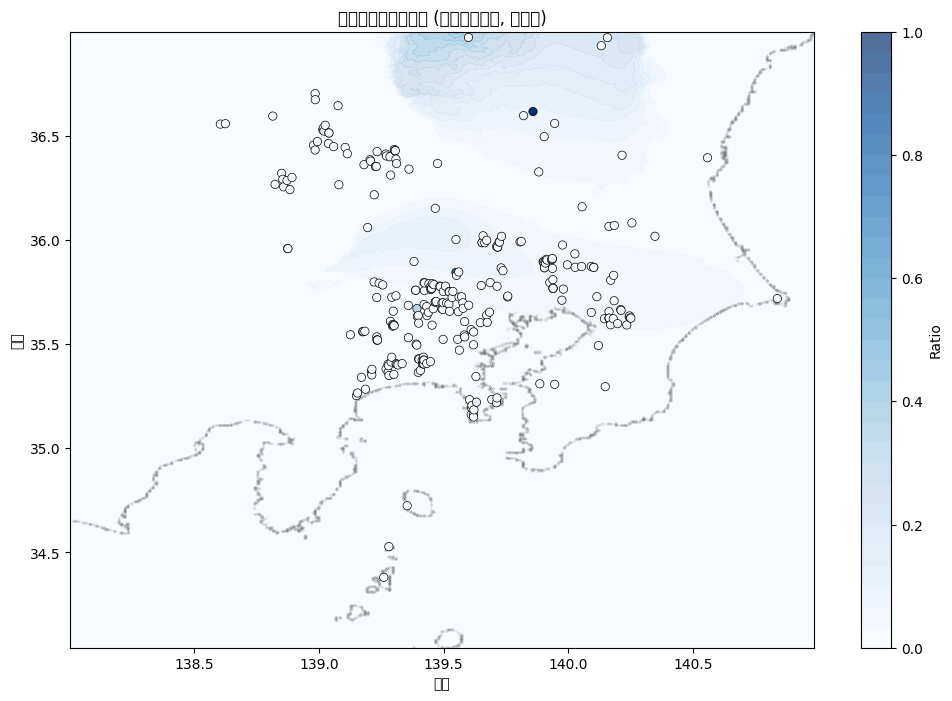

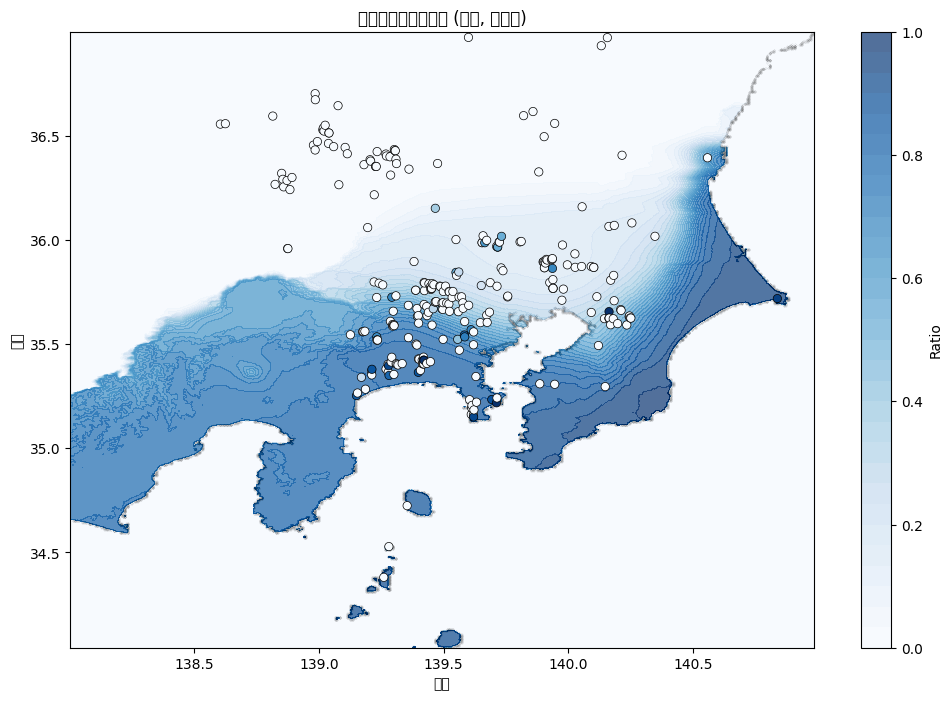

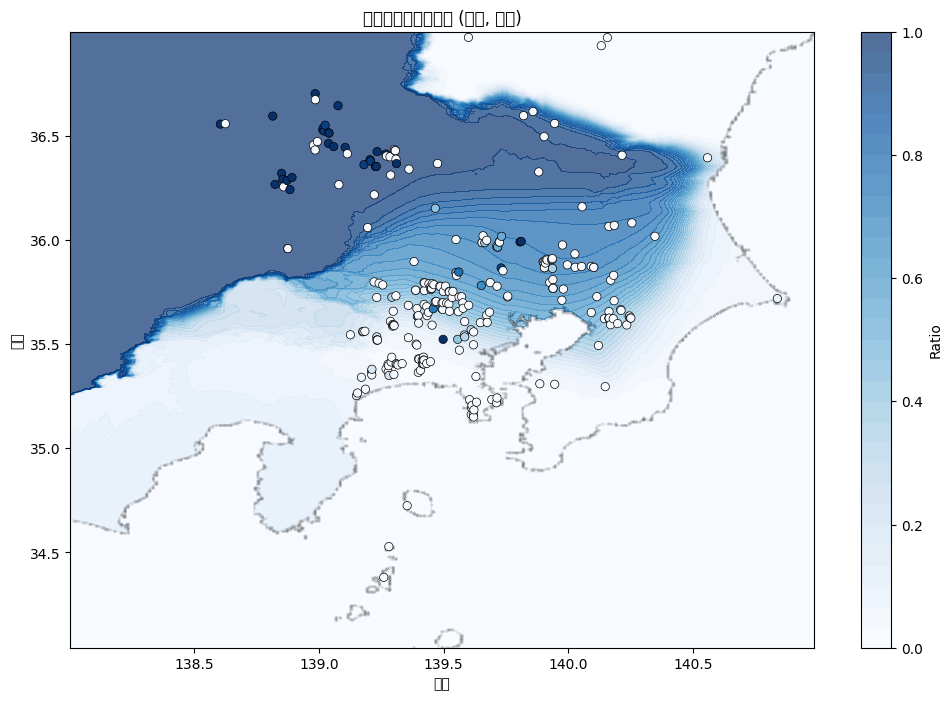

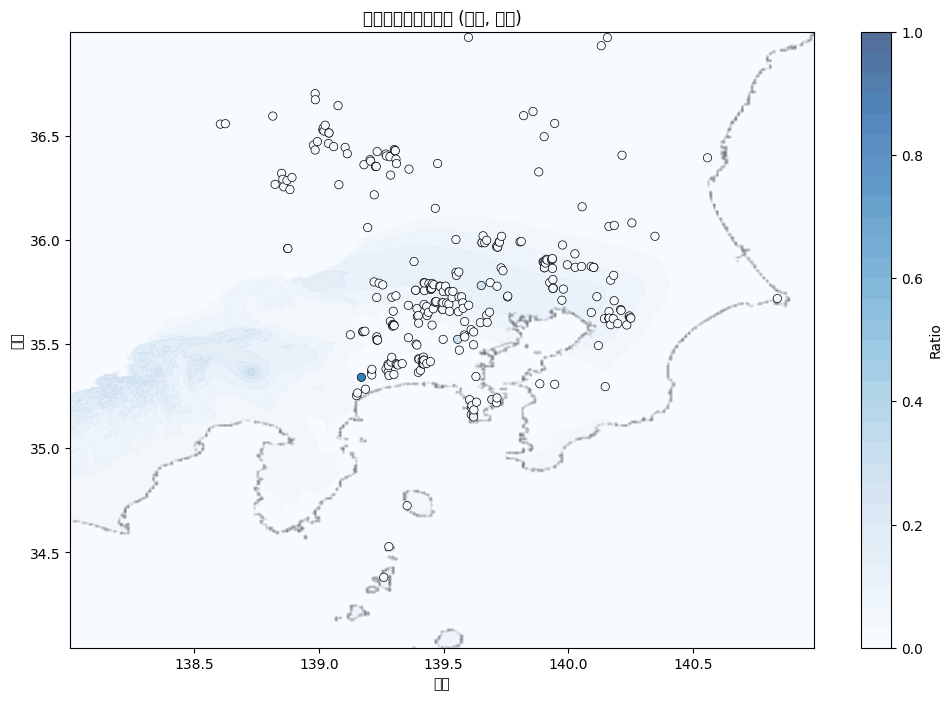

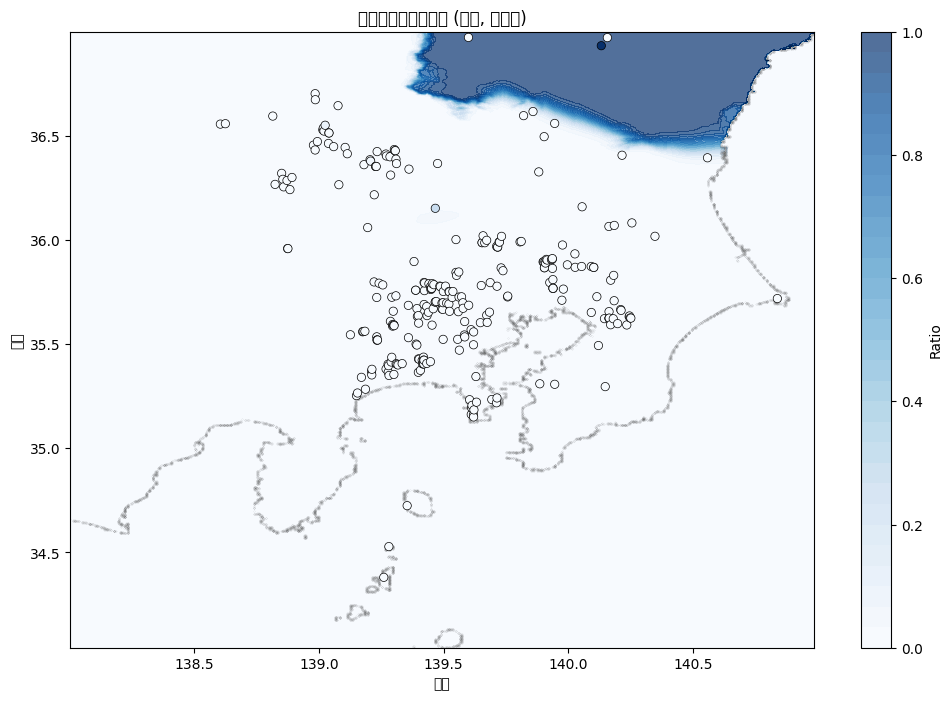

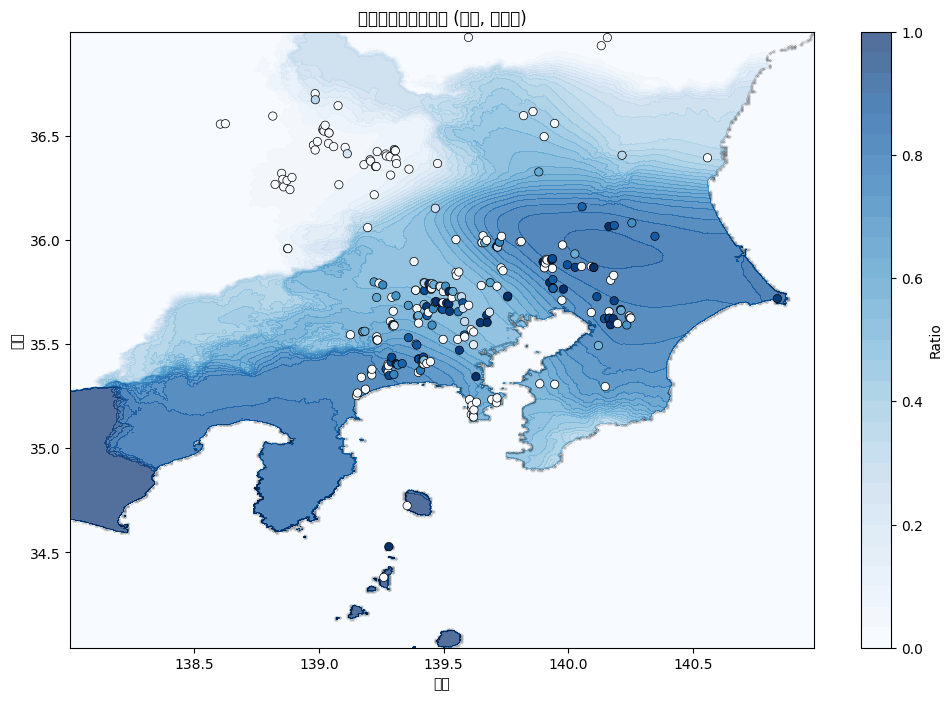

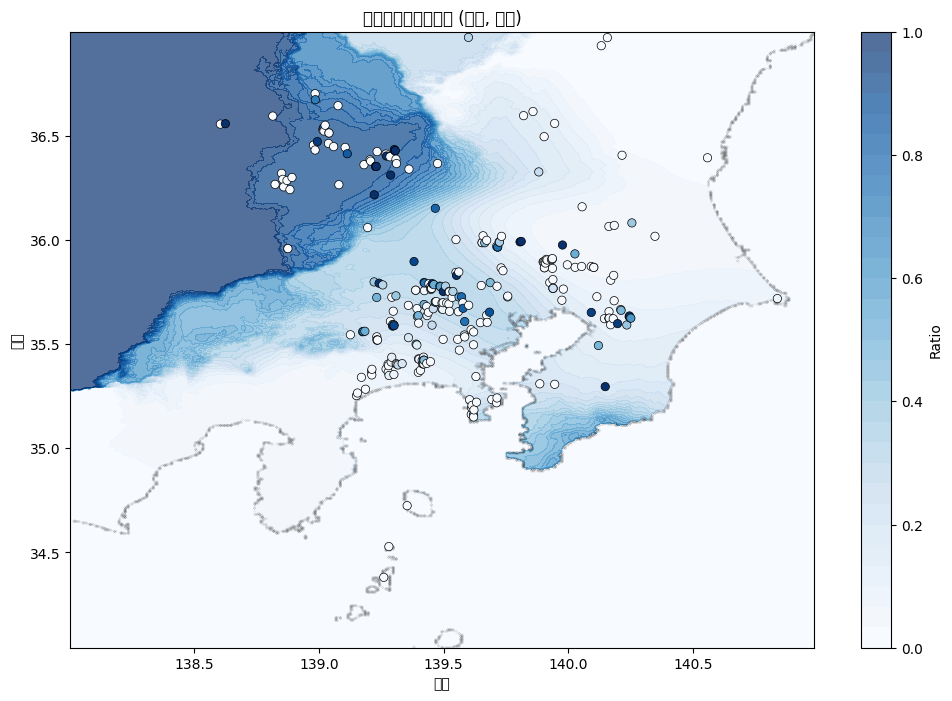

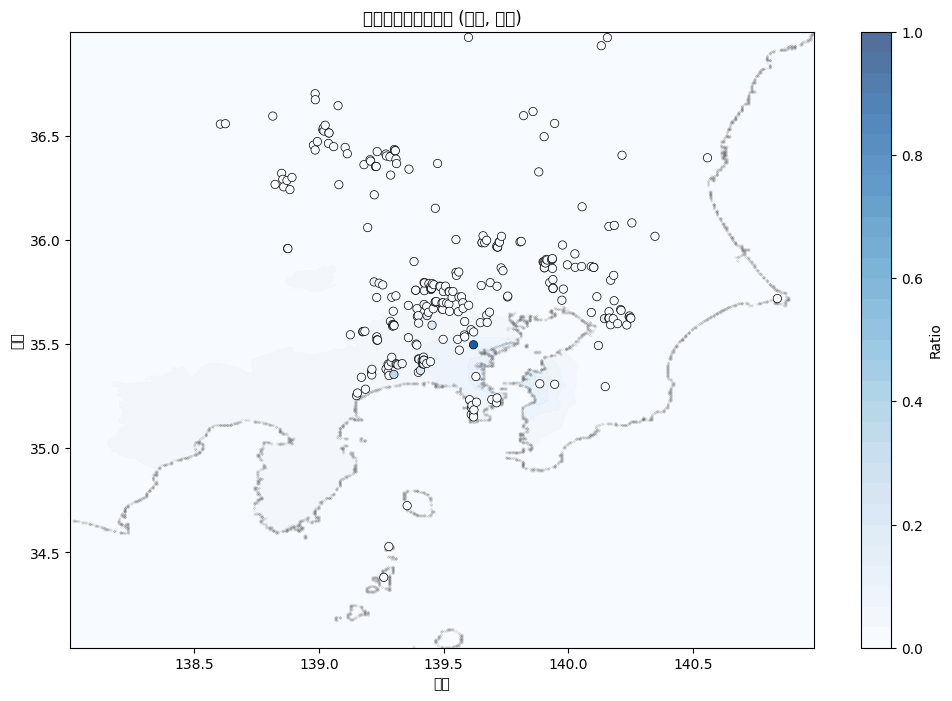

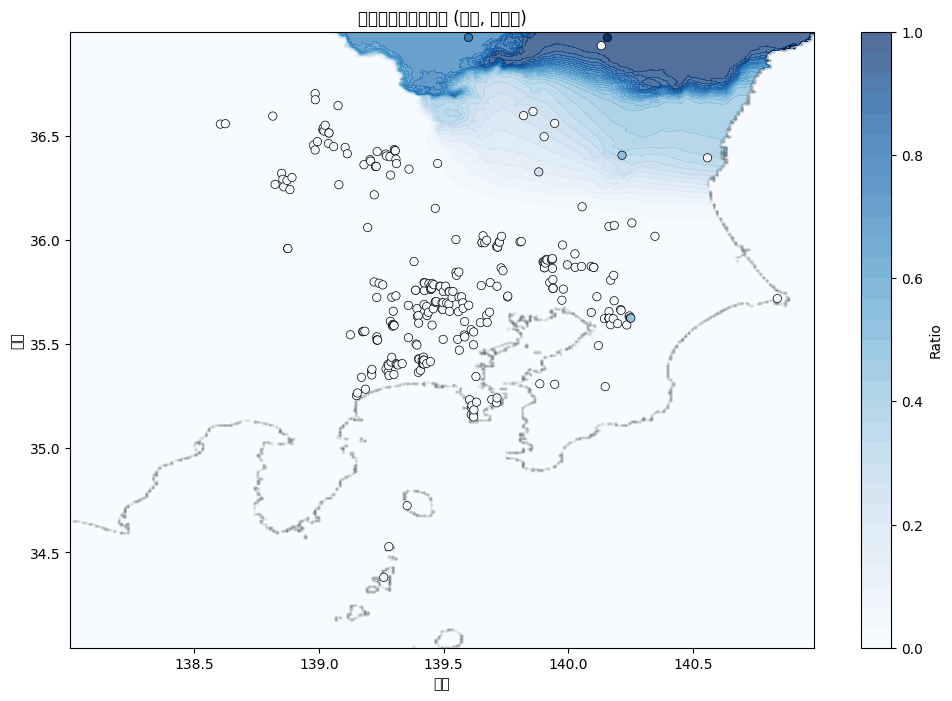

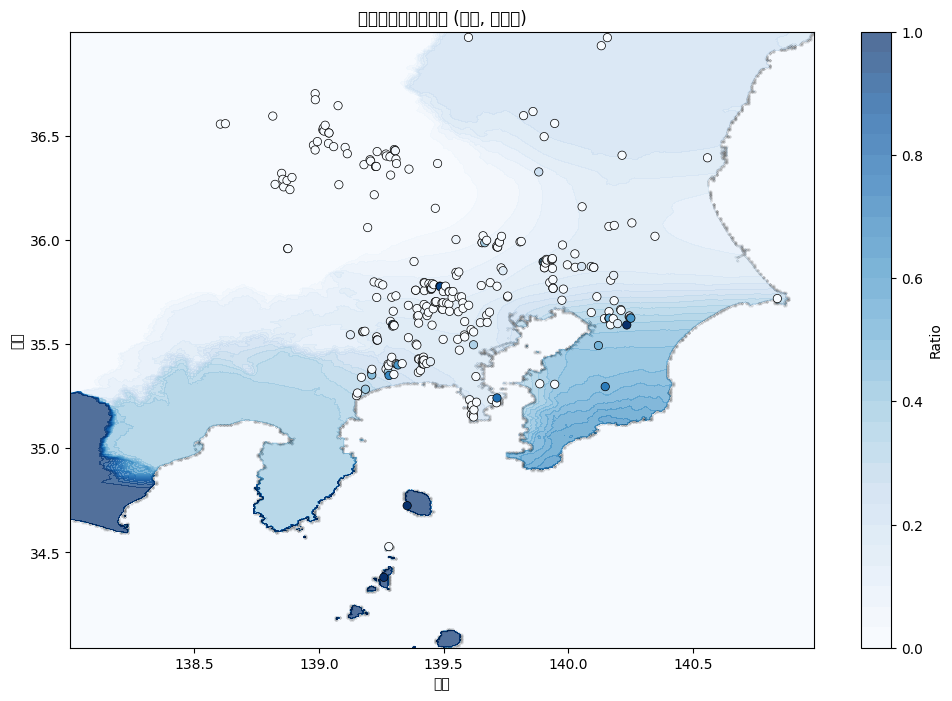

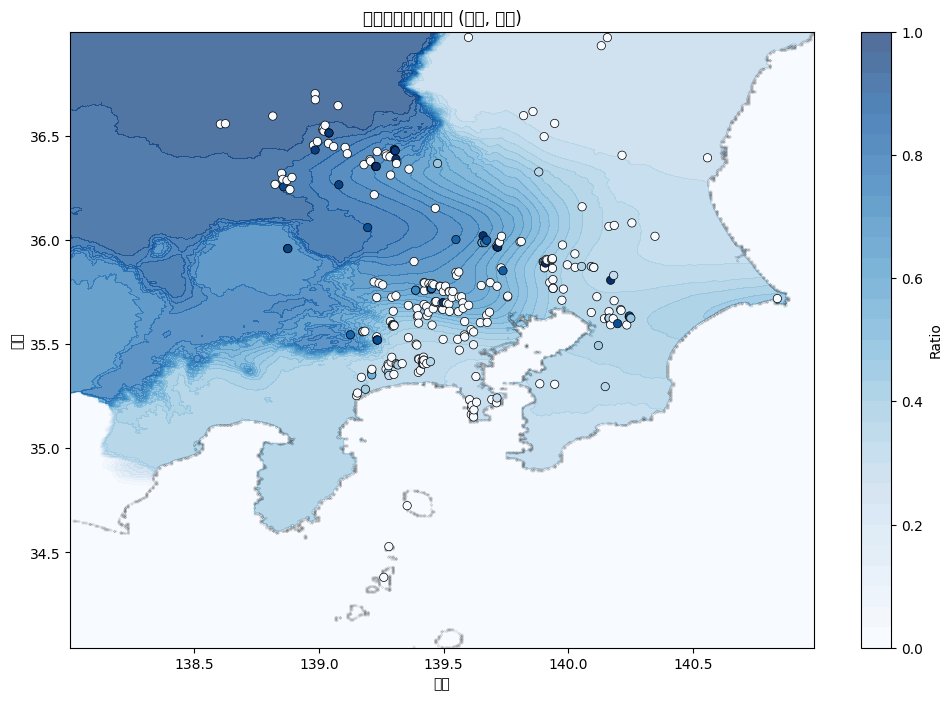

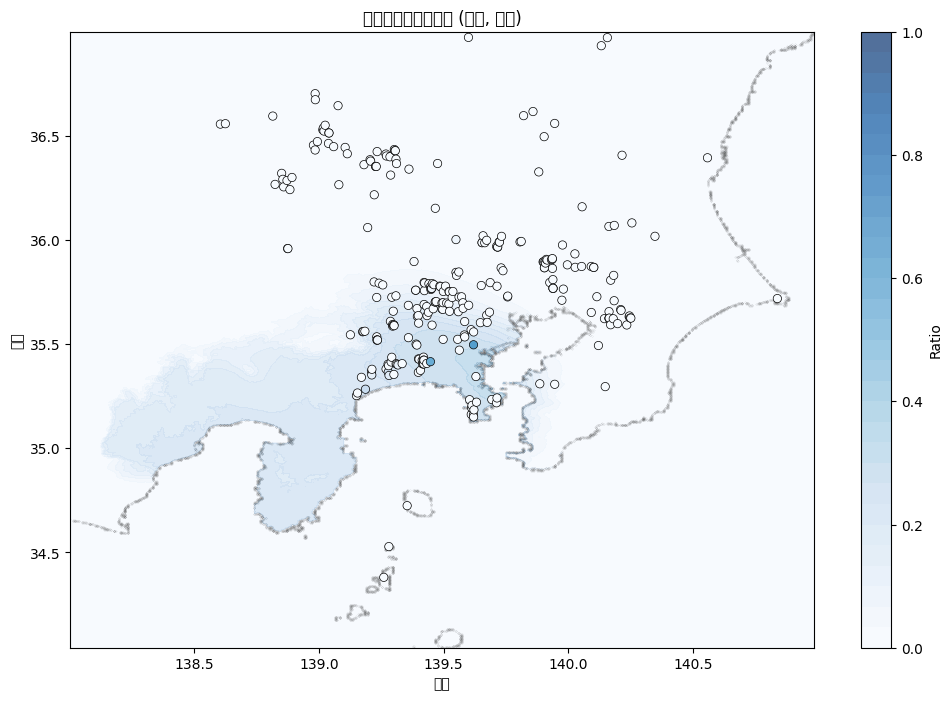

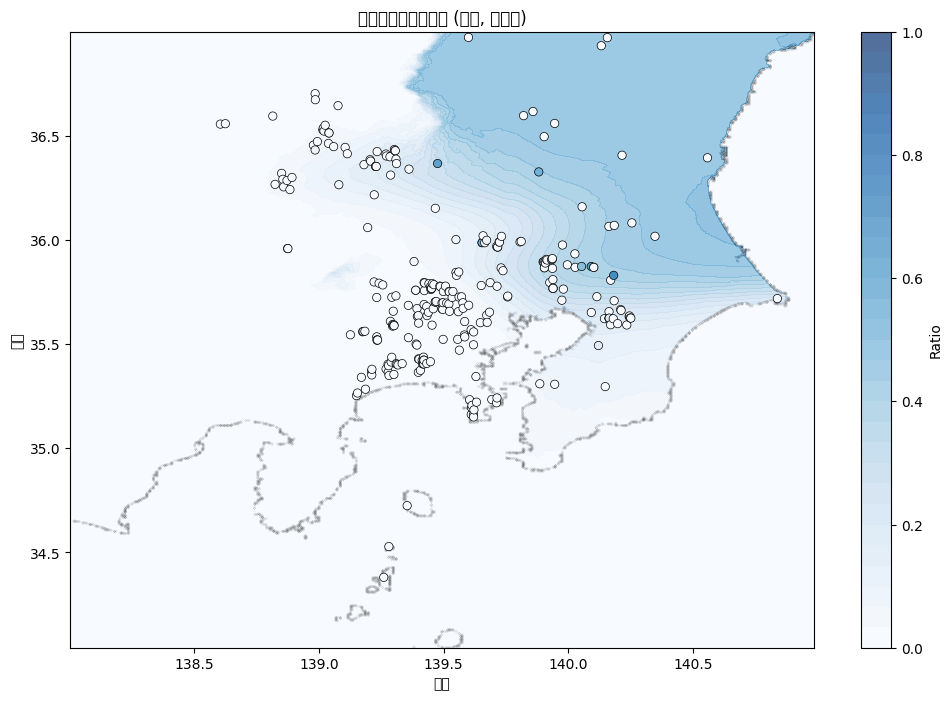

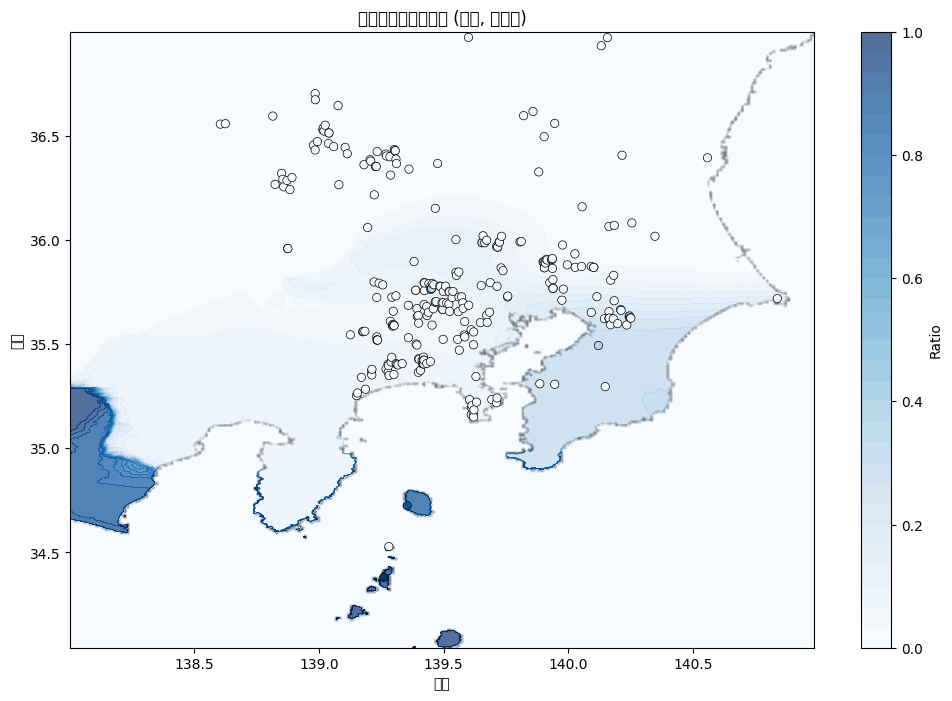

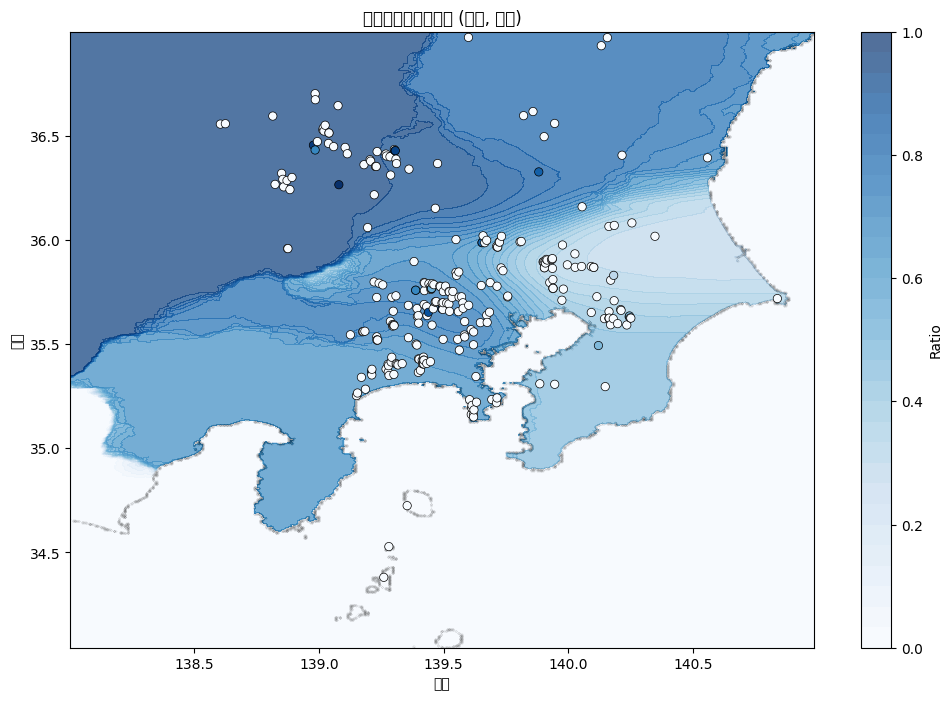

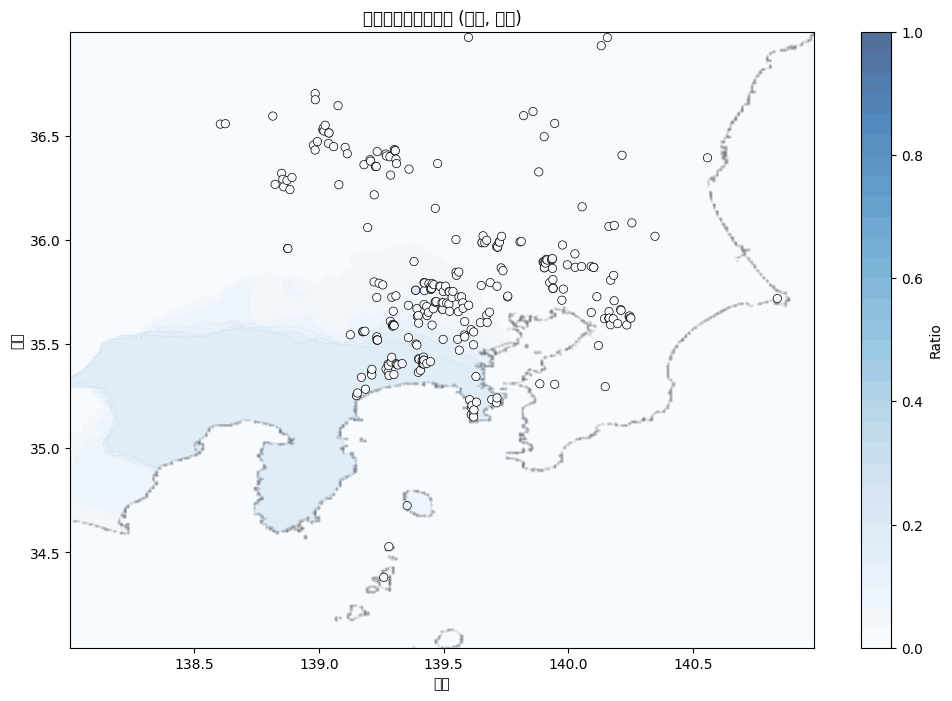

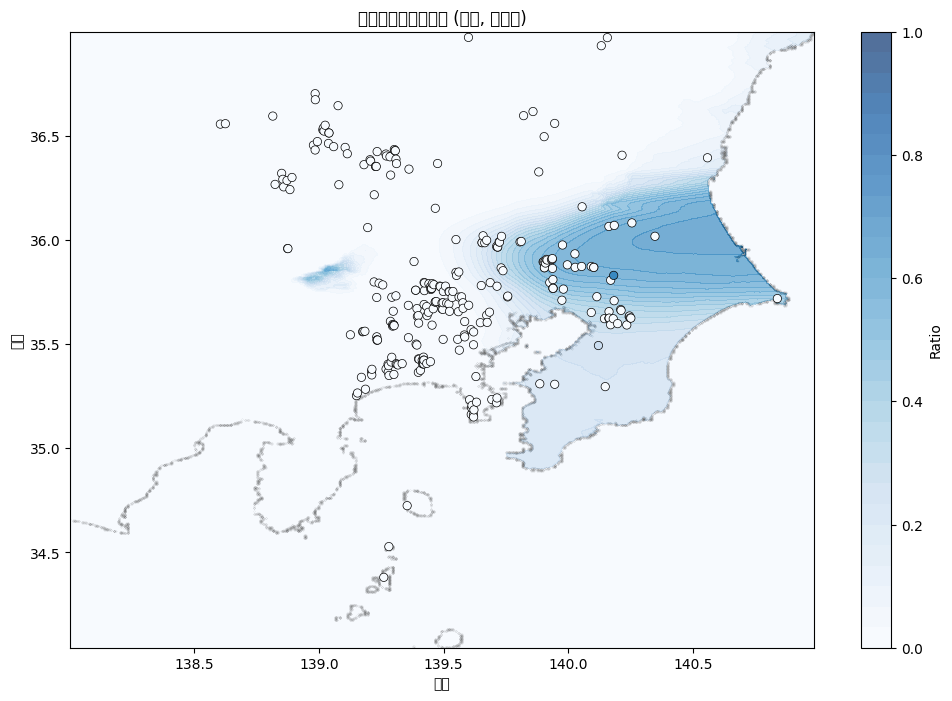

In [11]:
# 全時期・全産地の図を生成（保存はしない）
ObsidianVisualizer.plot_all_periods_origins(
    preprocessor.df_elevation,
    preprocessor.df_sites,
    config.time_periods,
    config.origins,
    save_dir=None,  # Noneにすると表示のみ
)

## 5. 結果の保存

In [12]:
# 結果の保存
pipeline.save_results(data_dir)


結果を保存しています: /home/ohta/dev/bayesian_statistics/data/
保存が完了しました。


## まとめ

このノートブックでは、Model 3rdの処理をクラス化して実行しました。

主な改善点：
1. **モジュール化**: 前処理、NW推定、IPP推定を独立したクラスに分離
2. **再利用性**: 各コンポーネントを個別に使用可能
3. **保守性**: コードの理解と修正が容易
4. **拡張性**: 新しい手法や変数の追加が簡単

生成されたファイル：
- `16_gdf_elevation_with_ratio_2nd.csv`: 標高データと推定結果
- `16_gdf_sites_with_ratio_2nd.csv`: 遺跡データと推定結果